In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# RandomForest (train raw)

In [ ]:
# Cargar datos de entrenamiento
df_train = pd.read_csv("../data/train_reviews.csv")
df_train['text'] = df_train['text'].fillna("")
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['year'] = df_train['date'].dt.year

# Seleccionar características adicionales de review, por ejemplo:
other_features = ['useful', 'funny', 'cool', 'year']
X_other_train = df_train[other_features].values

# Procesar el texto con TF-IDF en el training
tfidf = TfidfVectorizer(max_features=5000)
X_text_train_tfidf = tfidf.fit_transform(df_train['text'])

# Reducir la dimensionalidad del texto
svd = TruncatedSVD(n_components=50, random_state=42)
X_text_train_svd = svd.fit_transform(X_text_train_tfidf)

In [ ]:
X_text_train_svd.shape, X_other_train.shape

In [3]:
# Combinar las características numéricas con el embedding del texto
X_train = np.hstack([X_other_train, X_text_train_svd])
y_train = df_train['stars']

# Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Entrenar el modelo RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42, verbose=1, n_jobs=-1)
model.fit(X_train_final, y_train_final)

# Predecir en el conjunto de validación para evaluar
y_pred_val = model.predict(X_val)
print("MAE en validación:", mean_absolute_error(y_val, y_pred_val))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 18.7min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


MAE en validación: 0.720318928216396


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.4s finished


In [5]:
# Ahora, procesar el conjunto de test (sin ajustar de nuevo el vectorizador ni el SVD)
df_test = pd.read_csv('../data/test_reviews.csv')
df_test['text'] = df_test['text'].fillna("")
df_test['date'] = pd.to_datetime(df_test['date'])
df_test['year'] = df_test['date'].dt.year

X_other_test = df_test[other_features].values

# Transformar el texto de test con el vectorizador y el SVD ya ajustados
X_text_test_tfidf = tfidf.transform(df_test['text'])
X_text_test_svd = svd.transform(X_text_test_tfidf)

# Combinar las características
X_test = np.hstack([X_other_test, X_text_test_svd])

# Realizar las predicciones en el conjunto de test
predictions = model.predict(X_test)

# Crear el DataFrame con el formato requerido: review_id, stars
df_output = pd.DataFrame({
    'review_id': df_test['review_id'],
    'stars': predictions.round(0)  
})

# Exportar el CSV con las predicciones
df_output.to_csv('random_forest_review_predictions.csv', index=False)
print("Predicciones exportadas a 'test_review_predictions.csv'")

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    3.0s finished


Predicciones exportadas a 'test_review_predictions.csv'


# RandomForest (train + neg)

In [ ]:
df_train = pd.read_csv("../data/train_reviews_merged_neg.csv")
df_train['text'] = df_train['text'].fillna("")

df_train.sample(5)

,stars,useful,funny,cool,text,date,stars_neg,review_count_neg,is_open_neg,categories_neg,state_AZ_neg,state_FL_neg,state_IN_neg,state_LA_neg,state_MO_neg,state_NJ_neg,state_Others_neg,state_PA_neg,state_TN_neg
115165,5.0,-0.391093,-0.150312,-0.251644,Complete dining experience. Free valet parking...,2013,4.0,5.597167,True,Restaurante,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
87076,5.0,-0.391093,-0.150312,-0.251644,We used to live at the one in Boston- soooo sa...,2018,3.5,3.094144,True,Restaurante,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
265989,5.0,-0.391093,-0.150312,-0.251644,Great spot! Fanatabulous service and chef. Po...,2015,4.0,3.007013,True,Restaurante,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
802468,5.0,-0.391093,-0.150312,-0.251644,This place is where vegan heaven touches Earth...,2021,4.5,4.092185,True,Restaurante,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
233820,4.0,0.266410,-0.150312,0.762869,"1. Not much of an ice cream guy, but have to g...",2015,4.5,1.937684,True,Restaurante,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Omito state_* ya que no son muy representativas para el modelo

In [25]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X_numeric = df_train[["useful", "funny", "cool", "stars_neg", "review_count_neg", "categories_neg"]].copy()
X_numeric["is_open_neg"] = df_train["is_open_neg"].astype(int)

X_numeric

,useful,funny,cool,stars_neg,review_count_neg,categories_neg,is_open_neg
0,-0.391093,-0.150312,-0.251644,4.5,0.773303,Restaurante,1
1,0.266410,-0.150312,0.255613,2.5,-0.177212,Otros,1
2,-0.391093,-0.150312,-0.251644,2.5,-0.296027,Compras,1
3,-0.391093,-0.150312,-0.251644,4.5,0.226757,Restaurante,0
4,2.896420,1.654029,3.299152,4.0,-0.105924,Restaurante,1
...,...,...,...,...,...,...,...
967779,-0.062341,-0.150312,-0.251644,4.5,0.812908,Restaurante,0
967780,-0.391093,-0.150312,-0.251644,4.5,0.900038,Restaurante,1
967781,-0.391093,-0.150312,0.255613,4.5,1.961447,Restaurante,1
967782,-0.391093,-0.150312,-0.251644,4.5,21.478689,Restaurante,1


In [32]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
X_numeric['categories_neg'] = label_encoder.fit_transform(X_numeric['categories_neg'])

X_numeric.sample(5)

,useful,funny,cool,stars_neg,review_count_neg,categories_neg,is_open_neg
465239,0.266410,-0.150312,0.255613,3.5,0.511911,4,1
881721,-0.062341,0.300774,0.762869,4.0,5.755586,4,1
815782,-0.062341,-0.150312,-0.251644,4.5,16.488485,4,1
366091,-0.062341,0.300774,0.255613,4.5,11.110154,4,1
135020,-0.391093,-0.150312,-0.251644,3.5,0.828750,0,1


In [27]:
tfidf = TfidfVectorizer(stop_words='english', max_features=15000, ngram_range=(1, 2))
X_text = tfidf.fit_transform(df_train["text"])

svd = TruncatedSVD(n_components=100, random_state=42)
X_text_reduced = svd.fit_transform(X_text)

In [28]:
X_text_reduced.shape, X_numeric.shape, X_text.shape

((967784, 100), (967784, 7), (967784, 15000))

In [33]:
X_final = np.hstack([X_numeric.values, X_text_reduced])

y = df_train["stars"]

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42, verbose=1, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 36.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


MAE: 0.651963394319429


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.5s finished


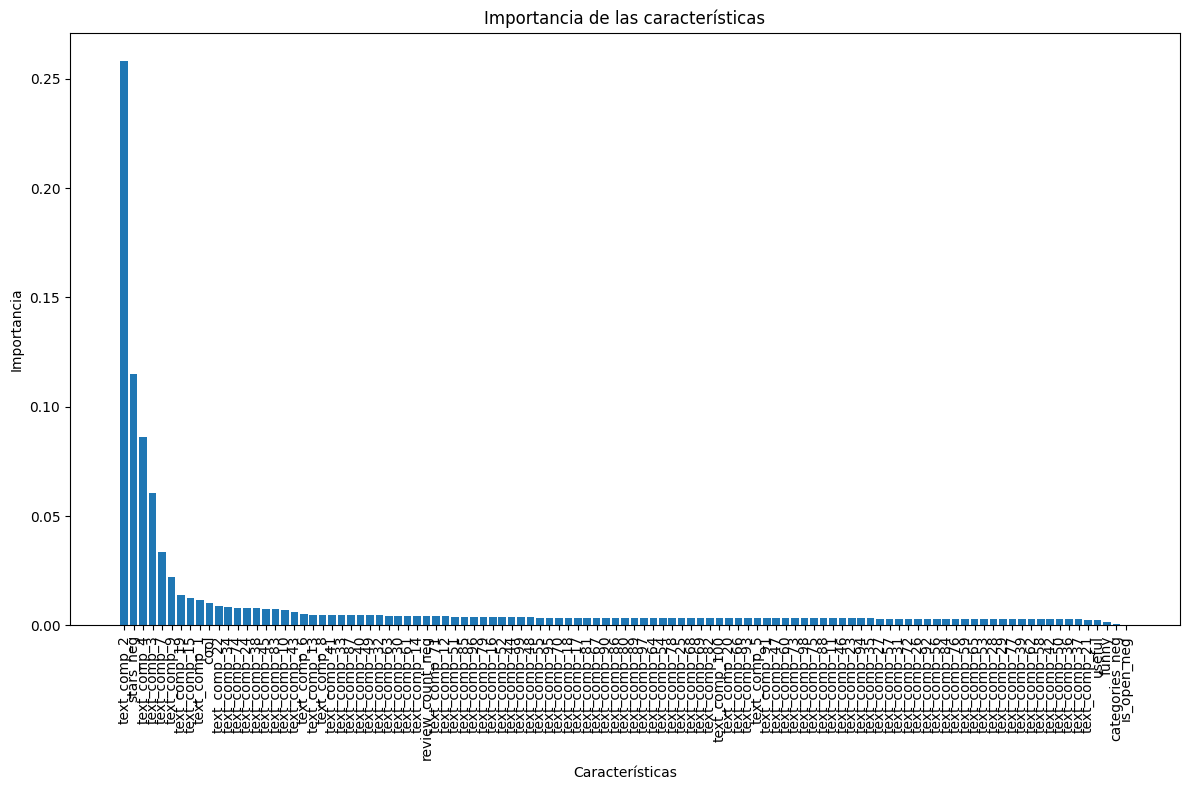

In [34]:
importances = model.feature_importances_

numeric_feature_names = list(X_numeric.columns)
text_feature_names = [f"text_comp_{i+1}" for i in range(X_text_reduced.shape[1])]
feature_names = numeric_feature_names + text_feature_names

indices = np.argsort(importances)[::-1]

# Crear la gráfica
plt.figure(figsize=(12, 8))
plt.title("Importancia de las características")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.tight_layout()
plt.show()

In [35]:
# Ahora, procesar el conjunto de test (sin ajustar de nuevo el vectorizador ni el SVD)
df_test = pd.read_csv('../data/test_reviews_merged_neg.csv')
df_test['text'] = df_test['text'].fillna("")

Y_numeric = df_test[["useful", "funny", "cool", "stars_neg", "review_count_neg", "categories_neg"]].copy()
Y_numeric["is_open_neg"] = df_test["is_open_neg"].astype(int)

Y_numeric

,useful,funny,cool,stars_neg,review_count_neg,categories_neg,is_open_neg
0,-0.063127,-0.164229,0.253789,4.5,1.375296,Restaurante,1
1,0.917552,-0.164229,0.759641,4.0,0.583200,Restaurante,1
2,0.263766,-0.164229,-0.252063,3.5,0.765382,Otros,1
3,0.263766,-0.164229,-0.252063,4.0,1.256481,Restaurante,1
4,-0.390020,-0.164229,-0.252063,2.5,3.561480,Hotelería,1
...,...,...,...,...,...,...,...
414760,-0.390020,-0.164229,-0.252063,4.0,15.997386,Restaurante,1
414761,-0.390020,-0.164229,-0.252063,4.0,-0.288106,Restaurante,1
414762,-0.390020,-0.164229,-0.252063,3.5,2.777305,Restaurante,0
414763,0.917552,-0.164229,0.253789,4.5,1.304007,Restaurante,0


In [36]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
Y_numeric['categories_neg'] = label_encoder.fit_transform(Y_numeric['categories_neg'])

Y_numeric.sample(5)

,useful,funny,cool,stars_neg,review_count_neg,categories_neg,is_open_neg
305082,0.263766,-0.164229,0.253789,4.5,4.488232,4,0
219285,-0.390020,-0.164229,-0.252063,4.0,0.567358,5,1
335469,-0.390020,-0.164229,-0.252063,2.5,-0.050477,4,0
246388,0.917552,-0.164229,0.253789,4.0,0.694093,4,0
89211,0.917552,-0.164229,-0.252063,3.5,0.298045,0,1


In [ ]:
Y_text_test_tfidf = tfidf.transform(df_test['text'])
Y_text_test_svd = svd.transform(Y_text_test_tfidf)

X_test = np.hstack([Y_numeric, Y_text_test_svd])

predictions = model.predict(X_test)

In [ ]:
# Crear el DataFrame con el formato requerido: review_id, stars
df_output = pd.DataFrame({
    'review_id': df_test['review_id'],
    'stars': predictions.round(0)
})

# Exportar el CSV con las predicciones
df_output.to_csv('random_forest_review_predictions_neg_1.csv', index=False)
print("Predicciones exportadas a 'random_forest_review_predictions_neg_1.csv'")

Predicciones exportadas a 'random_forest_review_predictions_neg.csv'
